In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/toxic-image/Screenshot from 2022-07-04 20-49-22.png
/kaggle/input/bertuncased-tensorflow-hub/Screenshot from 2022-07-05 12-24-19.png


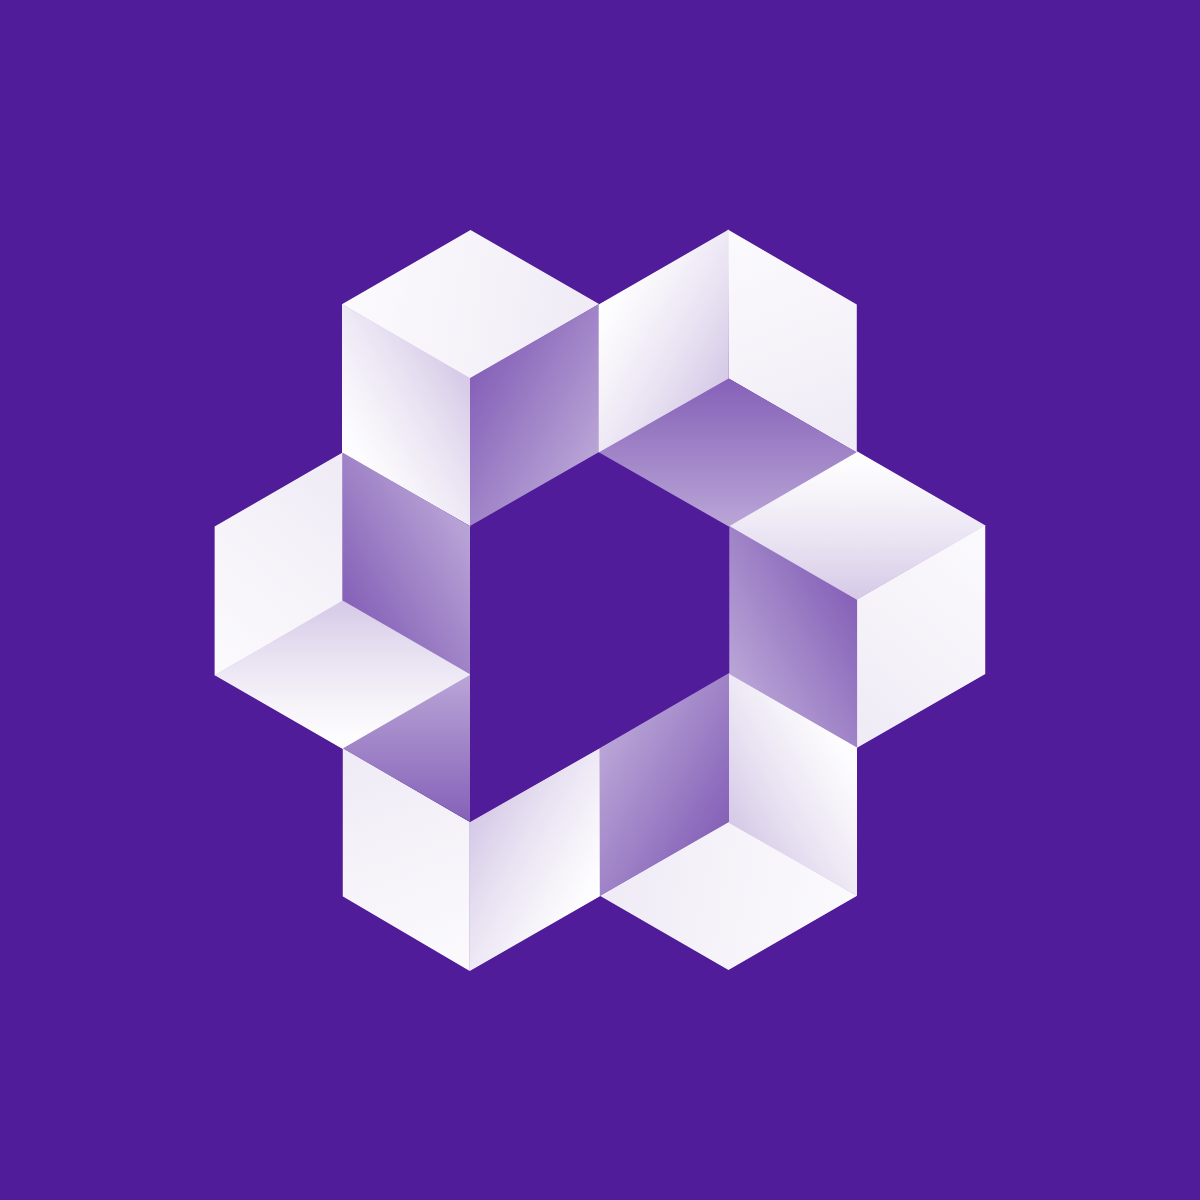

# **<center> Toxic Comment Classification Challenge</center>**

## **Problem Statement** 

### **“To build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate.”**

**Toxic Comment Classifier is a competition that has been organized by Jigsaw/Conversation AI and hosted on Kaggle. The data set for building the classification model was acquired from the competition site and it included the training set as well as the test set. The steps elaborated in the workflow below will describe the entire process from Data Pre-Processing to Model Testing.**

In [2]:
# Run the cell once, to download tesorflow-text
#uncomment the below line to install tensorflow-text
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attem

# **Import Required Libraries.**

In [3]:
import os
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import groupby

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# **Loading data**

In [5]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
print(f"Traing size \t  : {train.shape}\nTest size \t  : {test.shape}\nTest label size   : {test_labels.shape}\nsample_submission : {sample_submission.shape}")

Traing size 	  : (159571, 8)
Test size 	  : (153164, 2)
Test label size   : (153164, 7)
sample_submission : (153164, 7)


# **Top 5 comments**

In [6]:
# Top 5 Comments
for comment in train['comment_text'].iloc[:5]:
    print("\033[1;6m\n")
    print(comment)
    print("-"*100)



Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
----------------------------------------------------------------------------------------------------


D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
----------------------------------------------------------------------------------------------------


Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
----------------------------------------------------------------------------------------------------


"
More
I can't make any real suggestions on improvement - I wondered if the s

# **Maximum word length sentence in comments.**

In [7]:
train['comment_text_len'] = train['comment_text'].apply(lambda sentence : len(sentence.split()))
max_word_length = train['comment_text_len'].max()
print(f"Maximum word length : {max_word_length} \n")
print(train['comment_text'][train['comment_text_len'] == max_word_length].values[0][:1000])

Maximum word length : 1411 

I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER == == I AM AN LOSER ==== I AM AN LOSER ==

We can see that the duplicate sentence have been occured. let's write function to remove.

# **Removing duplicate sentence**

In [8]:
# Removing duplicates, if words occured more than  2 times in comment.
def remove_duplicates(text_before):
    my_dict = dict()
    text_after = list()
    for word in text_before.split():
        if word not in my_dict.keys():
            my_dict[word] = 1
        else:
            my_dict[word] = my_dict[word] + 1
    
    for key,value in my_dict.items():
        if value>=2:
            text_after.append(key)
        else:
            text_after.append(key)
    return " ".join(text_after)

In [9]:
train['comment_text_clean'] = train['comment_text'].apply(lambda text : remove_duplicates(text))
test['comment_text_clean'] = test['comment_text'].apply(lambda text : remove_duplicates(text))
# length of comments
train['comment_text_len'] = train['comment_text_clean'].apply(lambda x : len(x.split())) 

# **The length of the comments.**


In [10]:
train['comment_len'] = train['comment_text_clean'].str.len()
fig = px.histogram(train,x = 'comment_len',
                   title='Histogram of len of comments',
                   labels={'Number of samples, len of comments'},
                   opacity = 0.8,
                   log_y=True,
                   color_discrete_sequence = ['blue'])
fig.show()

# **Number of target counts**

In [11]:
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=("Toxic", 
                                    "Severe toxic",
                                    "Obscene", 
                                    "Threat",
                                    "Insult", 
                                    "Identity hate"))

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['toxic'].value_counts()),
              row=1, col=1)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['severe_toxic'].value_counts()),
              row=1, col=2)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['obscene'].value_counts()),
              row=1, col=3)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['threat'].value_counts()),
              row=2, col=1)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['insult'].value_counts()),
              row=2, col=2)

fig.add_trace(go.Bar(x = ['Yes','No'] , y=train['identity_hate'].value_counts()),
             row = 2,col = 3)
              
fig.show()

# **Cleaning text for better performance**

In [12]:
# "clean_text" function clean the text/comments 
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove links,remove punctuation
    and remove stop words containing numbers"""
    text = text.lower()                                            # Converts the text to lowercase using regex 
    text = re.sub(r"\[.*?\]","",text)                              # Replace's the text into 'nothing" if text is present inside squre brackets.
    text = re.sub("https?://\S+|www\.\S+","",text)                 # Removes the links from the comments.
    text = re.sub("<.*?>+","",text)                                # Remove unwanted
    text = re.sub("[%s]" % re.escape(string.punctuation),"",text)  # Remove punctuations
    text = re.sub("\n","",text)                                    # Remove next line symbols '\n'
    text = re.sub("\w*\d\w*","",text)                              # Takes only albhabet and digits.
    return text
train['comment_text_clean'] = train['comment_text_clean'].apply(lambda text : clean_text(text))
test['comment_text_clean'] = test['comment_text_clean'].apply(lambda text : clean_text(text))

**Removing stop words**

In [13]:
# Remove stop words from comments.
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
train['comment_text_clean'] = train['comment_text_clean'].apply(remove_stopwords)
test['comment_text_clean'] = test['comment_text_clean'].apply(remove_stopwords)

**Stemming**

In [14]:
# Stemming the texts
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
train['comment_text_clean'] = train['comment_text_clean'].apply(stemm_text)
test['comment_text_clean'] = test['comment_text_clean'].apply(stemm_text)

In [15]:
# define variable to training data and target data.
target_data = train[list_classes]
train_data = train['comment_text_clean']

# **BERT-BASE**

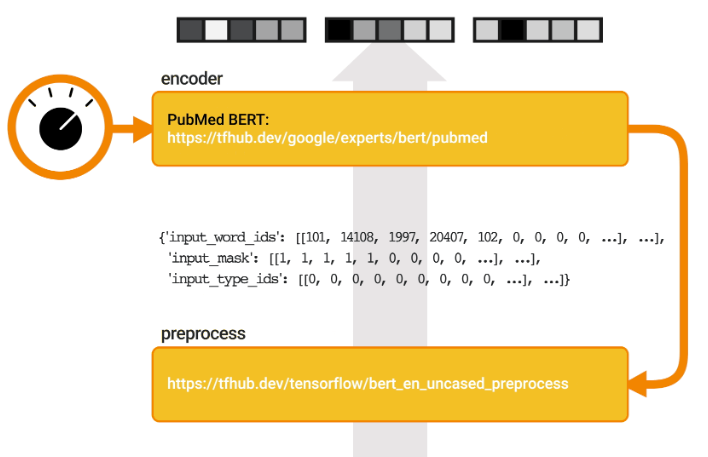


In [16]:
# Define BERT encoder url and processing url blocks from tensorflowhub
encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" 
preprocessing = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [17]:
bert_preprocessing_model = hub.KerasLayer(preprocessing) # preprocessing step in bert-base model
bert_model = hub.KerasLayer(encoder) # BERT-base model encoder

In [18]:
text_input = tf.keras.layers.Input(shape= (),dtype = tf.string,name = 'text')
preprocessing = bert_preprocessing_model(text_input)
output = bert_model(preprocessing)

# Linear layer
layer_1 = tf.keras.layers.Dropout(0.1,name = 'dropout')(output['pooled_output'])
layer_2 = tf.keras.layers.Dense(len(list_classes),activation = 'sigmoid',name = 'output')(layer_1)

model = tf.keras.Model(inputs = [text_input],outputs = [layer_2])

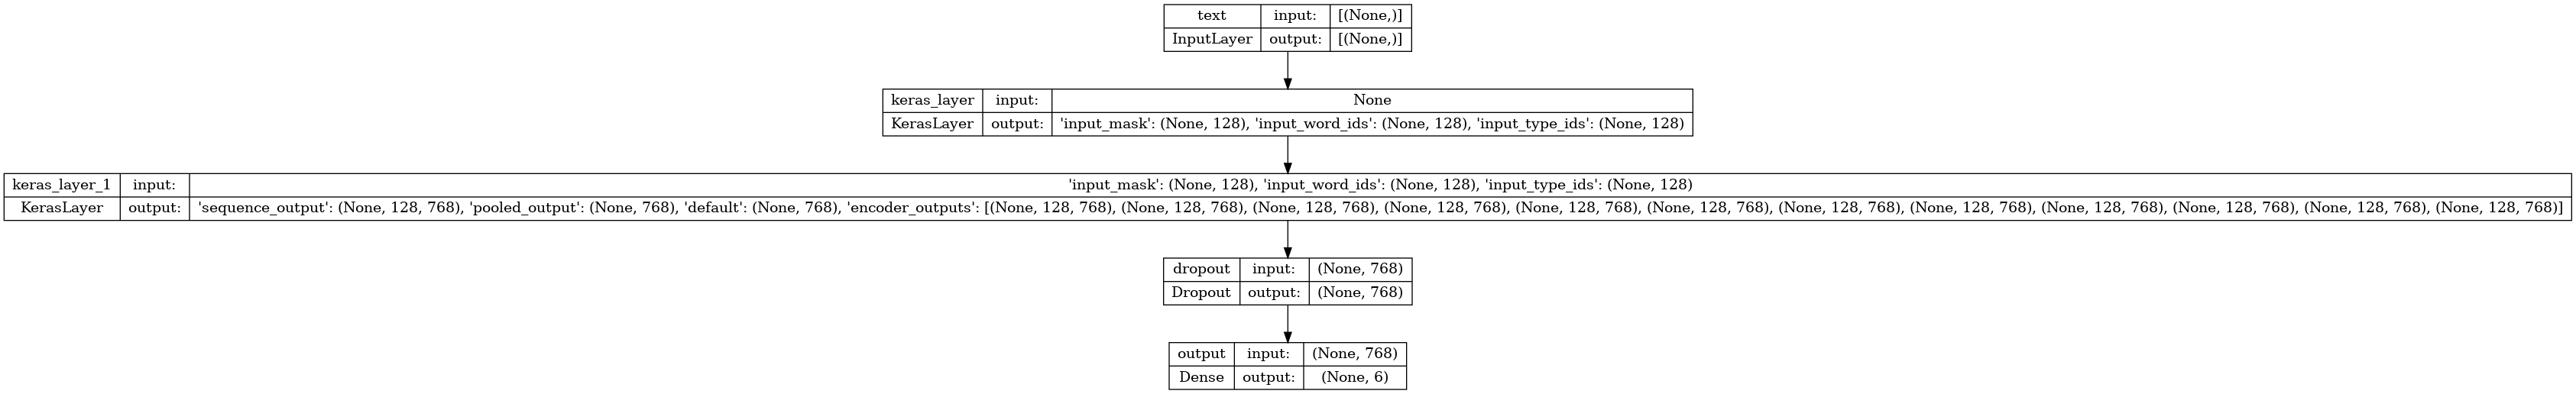

In [19]:
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True) # Plotting model shape 

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Traning process with 10 epochs.
model.fit(train_data,target_data,batch_size=32, epochs=3, validation_split=0.1)

Epoch 1/3
4488/4488 [==============================] - 1283s 283ms/step - loss: 0.0986 - accuracy: 0.8751 - val_loss: 0.0864 - val_accuracy: 0.9886
Epoch 2/3
4488/4488 [==============================] - 1261s 281ms/step - loss: 0.0846 - accuracy: 0.9560 - val_loss: 0.0813 - val_accuracy: 0.9856
Epoch 3/3
4488/4488 [==============================] - 1267s 282ms/step - loss: 0.0826 - accuracy: 0.9578 - val_loss: 0.0838 - val_accuracy: 0.9852


In [22]:
# Model predictions
model_predictions = model.predict([test['comment_text_clean']])

4787/4787 [==============================] - 1218s 254ms/step


In [23]:
model_predictions

array([[9.5578277e-01, 2.8783152e-01, 9.4899541e-01, 1.5647733e-01,
        7.9413223e-01, 2.1547458e-01],
       [4.2315807e-02, 8.1283436e-04, 1.1773587e-02, 6.8501527e-03,
        5.2430052e-03, 2.7083405e-03],
       [4.6371676e-02, 1.5130040e-03, 2.1314152e-02, 1.9855071e-03,
        9.7408174e-03, 6.7543271e-03],
       ...,
       [5.4260758e-03, 1.3610511e-04, 2.6504991e-03, 1.5324351e-04,
        1.1545010e-03, 5.2991573e-04],
       [5.2669868e-03, 9.4760435e-05, 1.1739044e-03, 6.6352967e-04,
        9.0867799e-04, 1.4105083e-03],
       [1.8485790e-01, 4.6652514e-03, 5.0569389e-02, 2.7975667e-02,
        3.7151467e-02, 7.2602103e-03]], dtype=float32)

# **Submission**

In [24]:
# getting ready for submission. 
sample_submission[list_classes] = model_predictions
sample_submission.to_csv('submission.csv', index=False)

In [25]:
# save and load trained model.
model.save('my_model')
trained_model = tf.keras.models.load_model('my_model')

# **Predicting**

In [26]:
# CLASSIFICATION
def classify(input_text,model,classes):
    trained_mdl =  model.predict([input_text])
    output = np.where(trained_mdl > 0.5,1,0)
    for i,j in zip(classes,output[0]):
        if j == 1:
            print(f"{i} :\t YES ")
        if j == 0:
            print(f"{i} :\t NO")
            
            
input = "you fucking bitch."
classify(input,trained_model,list_classes)

1/1 [==============================] - 1s 1s/step
toxic :	 YES 
severe_toxic :	 NO
obscene :	 NO
threat :	 NO
insult :	 NO
identity_hate :	 NO


In [27]:
classify('You bitch',trained_model,list_classes)

1/1 [==============================] - 0s 48ms/step
toxic :	 YES 
severe_toxic :	 NO
obscene :	 YES 
threat :	 NO
insult :	 YES 
identity_hate :	 NO
